## Inlämning 2 - Machine Learning - Jonathan S
#### This project builds on the previous assignment "Inlämning 1" with the same dataset. Data exploration and identifying cleaning needs has largely been done in the previous assignment.

#### The main goal of this project is to predict 'amount' (column representing customer spending) using the features 'category', 'size' and 'qty'. There is an argument to using more features but in this project I am more focused on learning the fundamentals rather than creating the most optimal model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# pandas option to display all columns when printing df.head()
pd.set_option('display.max_columns', None)

In [2]:
# reading the data 
# converting the 23rd column 'Unnamed 22' column to string, which originally had a mix of bool and NaN values (nan and False)
df = pd.read_csv('AmazonDataSales.csv', dtype={23: str})
df.head(0)

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22


### Data Cleaning and Preprocessing

##### The column names are a mess of mixed upper/lowercase, blankspaces and hyphens so in the following block we will clean them and format to snake_case

In [3]:
# clean the column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '_')
df.head(0)

,index,order_id,date,status,fulfilment,sales_channel,ship_service_level,style,sku,category,size,asin,courier_status,qty,currency,amount,ship_city,ship_state,ship_postal_code,ship_country,promotion_ids,b2b,fulfilled_by,unnamed:_22


#### Getting a better view of the data and how many missing values we have in each column. <br>
- Since we already decided to only use 'category', 'size' and 'qty' as our features, the other columns are not very interesting to us. However, as I found out in the previous assignment, there are some inconsistencies in 'qty' and 'amount' that we need to handle and we might need columns like 'status' and 'courier_status' to help guide those decisions.

In [4]:
# print the shape of the data
print(f' cols, rows: ', df.shape)
# checking for nan values in all columns
print('count of nan values:')
# count of nan values in all columns descending order
print(df.isna().sum().sort_values(ascending=False).head(11))

 cols, rows:  (128975, 24)
count of nan values:
fulfilled_by          89698
promotion_ids         49153
unnamed:_22           49050
currency               7795
amount                 7795
courier_status         6872
ship_country             33
ship_postal_code         33
ship_state               33
ship_city                33
ship_service_level        0
dtype: int64


#### Handling the zero values in 'qty' and 'amount'
- Since this is our second go at this dataset we are already familiar with the nature of zero values in 'qty' and 'amount' columns. I have decided to drop the rows with nan values in 'amount' which is 5.9% of total rows, because the all the orders were cancelled as we found out from the 'status' column.


In [5]:
total_rows = df.shape[0]
print(f'total rows: {total_rows}')

# drop rows with null values in 'amount'
df = df.dropna(subset=['amount'])

total_rows_after_drop = df.shape[0]
print(f'total rows after drop: {total_rows_after_drop}')

total rows: 128975
total rows after drop: 121180


#### After running the following codeblock we can see that we have zero values in both 'amount' and 'qty' but they are never both zero on row level <br>
- We can see that when qty == 0 we only have status = Cancelled, since the goal with this exercise is to predict 'amount' I have decided to not work with Cancelled orders. <br>
So in the following block we drop those rows. <br><br>
- We can also see that when amount == 0 we have various forms of Shipped and Pending status on the orders and no real explanation in the data as to why these items are "free". <br>
With this in mind i feel a loss of 2% of remaining rows is acceptable when the main goal is to predict amount with relevant data.

In [6]:
rows_amount_zero = len(df[df['amount'] == 0])
rows_qty_zero = len(df[df['qty'] == 0])

amount_zero_mask = df[df['amount'] == 0]
qty_zero_mask = df[df['qty'] == 0]

print(f'amount column zeros:', rows_amount_zero)
print(f'qty column zeros:', rows_qty_zero)
print(f'amount and qty column zeros:', rows_amount_zero & rows_qty_zero)
print('-'*50)
print('value counts of status when qty == 0')
print(qty_zero_mask['status'].value_counts())
print('-'*50)
print('value counts of status when amount == 0')
print(amount_zero_mask['status'].value_counts())
print('-'*50)
print(f'total rows where amount == 0:', rows_amount_zero)
print(f'total rows remaining:', total_rows_after_drop)
print(f'total rows after dropping rows:', total_rows_after_drop - rows_amount_zero)

amount column zeros: 2343
qty column zeros: 5136
amount and qty column zeros: 0
--------------------------------------------------
value counts of status when qty == 0
status
Cancelled    5136
Name: count, dtype: int64
--------------------------------------------------
value counts of status when amount == 0
status
Shipped                          1518
Shipped - Delivered to Buyer      716
Shipped - Returned to Seller       51
Shipped - Picked Up                28
Pending                            17
Pending - Waiting for Pick Up       9
Shipped - Lost in Transit           2
Shipped - Returning to Seller       2
Name: count, dtype: int64
--------------------------------------------------
total rows where amount == 0: 2343
total rows remaining: 121180
total rows after dropping rows: 118837


In [7]:
# drop rows where qty is 0, amount is 0
drop_qty_zero_mask = df['qty'] != 0
drop_amount_zero_mask = df['amount'] != 0

df = df[drop_qty_zero_mask]
df = df[drop_amount_zero_mask]

total_rows_final = df.shape[0]

print(f'total remaining rows: ', total_rows_final, '/', total_rows)

total remaining rows:  113701 / 128975


C:\Users\jonat\AppData\Local\Temp\ipykernel_11912\2351954306.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[drop_amount_zero_mask]


### Feature Selection <br>


In [8]:
# limit the columns to the ones we want to use as features
columns_to_keep = ['category', 'size', 'qty', 'amount']
df = df[columns_to_keep]
df.head(3)

,category,size,qty,amount
1,kurta,3XL,1,406.0
2,kurta,XL,1,329.0
4,Top,3XL,1,574.0


#### Cleaning the data my trimming potential whitespaces and converting to lower and uppercase depending on the nature of the data

In [9]:
# clean the data by converting the 'category' strings to lowercase and removing any empty spaces
df['category'] = df['category'].str.lower().str.strip()
# clean the 'size' column by converting the strings to uppercase, removing any empty spaces, and replacing 'FREE' with 'Free'
df['size'] = df['size'].str.upper().str.strip().str.replace('FREE', 'Free')

### Model Selection

#### First we check the numerical columns distribution and detect outliers

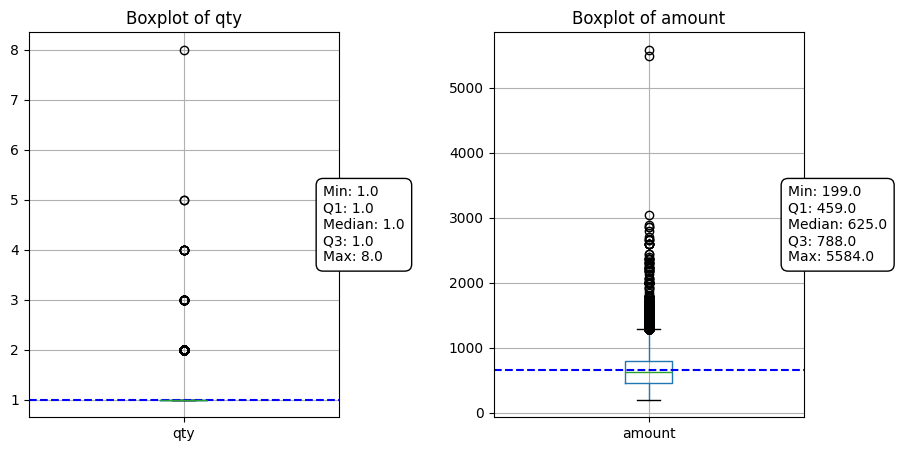

In [10]:
# box plots for investigating outliers in qty and amount columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, col in enumerate(['qty', 'amount']):
    df.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
    axes[i].axhline(y=df[col].mean(), color='b', linestyle='dashed')
    
    # adding describe to the boxplots
    stats = df[col].describe()
    text = f"Min: {stats['min']}\nQ1: {stats['25%']}\nMedian: {stats['50%']}\nQ3: {stats['75%']}\nMax: {stats['max']}"
    axes[i].text(0.95, 0.5, text, transform=axes[i].transAxes, verticalalignment='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.subplots_adjust(wspace=0.5)

plt.show()


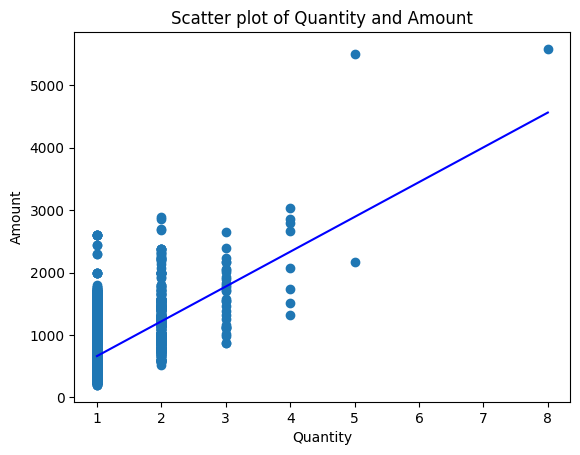

In [11]:
# scatter plot qty and amount
plt.scatter(df['qty'], df['amount'])
plt.xlabel('Quantity')
plt.ylabel('Amount')
plt.plot(np.unique(df['qty']), np.poly1d(np.polyfit(df['qty'], df['amount'], 1))(np.unique(df['qty'])), color='blue')
plt.title('Scatter plot of Quantity and Amount')
plt.show()

#### Takeaways:
- Outliers: we can easily see that there are outliers in both qty and amount, we can also see that some of the outliers has a relationship
- If we are using a linear regression model we should probably handle these outliers in some form eg. log transformation
- Overall I find it difficult to determine linearity, I'm leaning towards Decision Tree that can handle non-linear relationships better.

#### Getting a better look at 'category' and 'size'

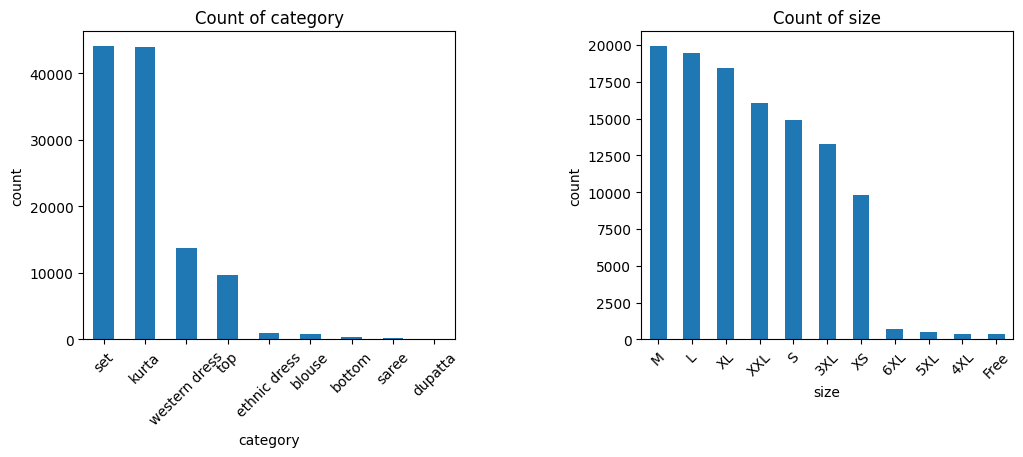

In [12]:
# bar plots for 'category' and 'size'
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, col in enumerate(['category', 'size']):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"Count of {col}")
    axes[i].set_ylabel('count')
    axes[i].set_xlabel(col)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.subplots_adjust(wspace=0.5)

plt.show()

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# encode 'category' and 'size' columns
df['category_encoded'] = label_encoder.fit_transform(df['category'])
df['size_encoded'] = label_encoder.fit_transform(df['size'])

## Correlation Matrix

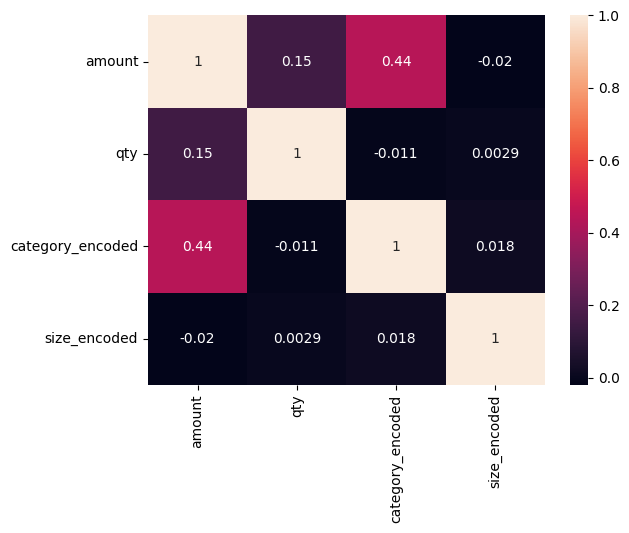

In [14]:
# correlation matrix
corr_cols = ['amount', 'qty', 'category_encoded', 'size_encoded']
correlation_matrix_label = df[corr_cols].corr()
sns.heatmap(correlation_matrix_label, annot=True)
plt.show()

In [15]:
# One-hot encode 'category' and 'size' columns
df_encoded = pd.get_dummies(df, columns=['category', 'size'])
df_encoded = df_encoded.drop(columns=['category_encoded', 'size_encoded'])

<Axes: >

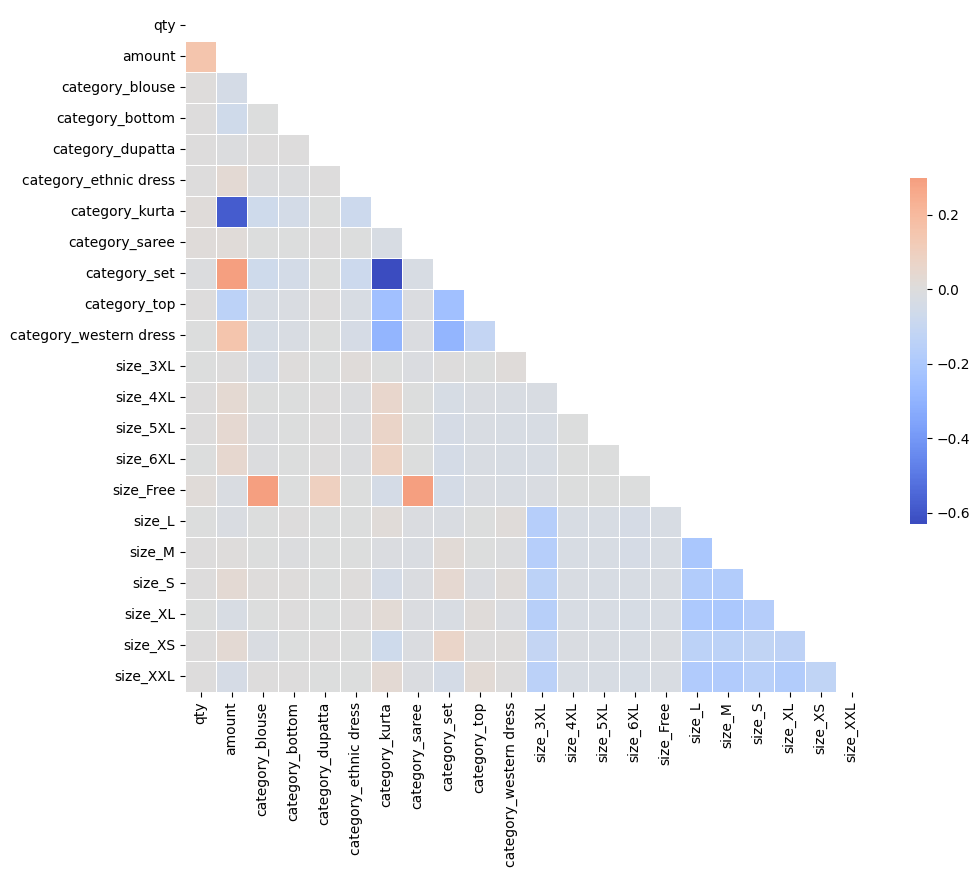

In [16]:
corr = df_encoded.corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


### Takeaways: <br>
- The heatmap of features shows low correlations between features and the 'amount'. This suggests no single feature strongly predicts the target on its own.
- With these findings in mind, I'm choosing to go with a Decision Tree Regressor model which handles non-linear relationships in the data more effectively than a Linear model.
- Regarding outliers: I researched how to handle outliers when working with Decision Trees and found that the model is not sensitive to outliers, so the plan is to leave it as is for now.

In [17]:
# drop category encoded and size encoded columns
df = df.drop(columns=['category_encoded', 'size_encoded'])

In [18]:
df.head(1)

,category,size,qty,amount
1,kurta,3XL,1,406.0


In [19]:
# one-hot encode 'category' and 'size' columns
categorical_features = ['category', 'size']
one_hot_encoder = OneHotEncoder()
transformer = ColumnTransformer(transformers=[('cat', one_hot_encoder, categorical_features)], remainder='passthrough')
X = transformer.fit_transform(df.drop('amount', axis=1))

# get feature names
feature_names = transformer.get_feature_names_out()
feature_names_print = feature_names.tolist()
print(feature_names_print)
print(f' count of features: ', len(feature_names_print))

['cat__category_blouse', 'cat__category_bottom', 'cat__category_dupatta', 'cat__category_ethnic dress', 'cat__category_kurta', 'cat__category_saree', 'cat__category_set', 'cat__category_top', 'cat__category_western dress', 'cat__size_3XL', 'cat__size_4XL', 'cat__size_5XL', 'cat__size_6XL', 'cat__size_Free', 'cat__size_L', 'cat__size_M', 'cat__size_S', 'cat__size_XL', 'cat__size_XS', 'cat__size_XXL', 'remainder__qty']
 count of features:  21


In [20]:
# split the data into train and test sets
y = df['amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [22]:
y_pred = decision_tree_model.predict(X_test)
mae = round(mean_absolute_error(y_test, y_pred), 3)
mse = round(mean_squared_error(y_test, y_pred), 3)
rmse = round(np.sqrt(mse), 3)
r2 = round(r2_score(y_test, y_pred), 4)
stdev = round(y.std(), 2)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'STDDEV: {stdev}')
print(f'R²: {r2}')

MAE: 140.66
MSE: 37084.46
RMSE: 192.573
STDDEV: 269.54
R²: 0.4994


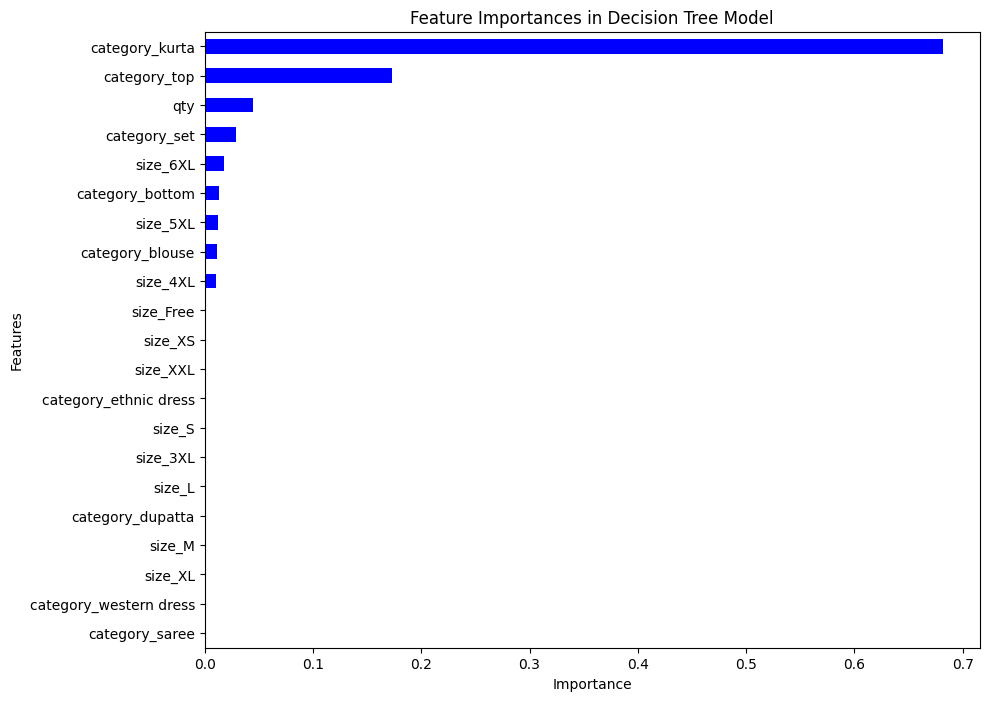

In [23]:
feature_importances = decision_tree_model.feature_importances_
encoded_feature_names = transformer.named_transformers_['cat'].get_feature_names_out(categorical_features)
remaining_feature_names = [name for name in df.drop(columns=categorical_features + ['amount']).columns]
all_feature_names = list(encoded_feature_names) + remaining_feature_names
importances_series = pd.Series(feature_importances, index=all_feature_names)
sorted_importances_series = importances_series.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sorted_importances_series.plot(kind='barh', color='blue')
plt.title('Feature Importances in Decision Tree Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.show()